# Define Iterative label Spreading function

This function takes a set of N points with M features. Some of the N points are initially unlabelled. It returns a fully labelled set, the order in which points were labelled, and the distance to the neighbour from which their label was inherited.   

The labels are spread from the labelled points to the unlabelled points by 1st-nearest-neighbour Euclidean distances in feature space, which can be performed: 
1. Iteratively
     - The unlabelled point closest to any labelled point is relabelled first
     - The list of labelled points is updated
     - The above are repeated until all points are labelled 
2. Simultaneously: 
     - all unlabelled points are relabelled with regard to the initially labelled set



## Import required packages

Array management is achieved using pandas dataFrames for ease of indexing.

In [140]:
from matplotlib import pyplot as plt 
import time
import numpy as np 
import pandas as pd 
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.preprocessing import StandardScaler

## Function definition

In [141]:
def ILS(df, labelColumn , outColumn = 'LS' ,  iterative = True ) :
    ''' 
    @author: amanda.parker@data61.csiro.au
    Citation and implemenatation details : "" 
    
    Apply iterative label spreading in a multi-dimensional feature-space. 
    Returns labels for all points and the order-labelled 
    and distance-when-labelled for all newly labelled points. 
    INPUTS : 
        df = pandas dataFrame: 
            all features are columns (and only those) + 
            one column holding initial labels  
        iterative = boolean : 
            True : label spreading to unlabelled points applied iteratively       
            False : all unlabelled points relabelled with regard to 
                    initially labelled set 
        labelColumn = String: 
            Column name for column that holds initial labels. 
            0 = to be labelled
            positive integers = assigned label.  
    OUTPUTS : 
        pandas dataSeries: 
            index : same index input df
            name : outColumn 
            data : Labels for all points 
                (all values 0 replaced with a positive integer)
        pandas dataFrame: 
            Only contains points that were labelled by ILS 
            index : same as input df *reordered by order labelled*
            columns: 
                minR : distance when relabelled  
                IDclosestLabelled : ID of point label recieved from'   
     '''
    
    featureColumns = [ i for i in df.columns if i != labelColumn ]
    # Keep original index columns in DF 
    indexNames = list(df.index.names)
    oldIndex = df.index
    df = df.reset_index(drop = False)
    
    # separate labelled and unlabelled points 
    labelled = [ 
        group for group in df.groupby(df[labelColumn] != 0 )
        ][True][1].fillna(0)
    unlabelled = [ 
        group for group in df.groupby(df[labelColumn] != 0 ) 
        ][False][1]
    
    # lists for ordered output data
    outD = []
    outID = []
    closeID = []
    
    # Continue while any point is unlabelled 
    while len(unlabelled) > 0 :
        # Calculate labelled to unlabelled distances matrix (D) 
        D = pairwise_distances(
            labelled[featureColumns].values,
            unlabelled[featureColumns].values)
        
        # Find the minimum distance between a labelled and unlabelled point 
        # first the argument in the D matrix 
        (posL, posUnL) = np.unravel_index(D.argmin(), D.shape)
        # then convert to an index ID in the data frame 
        # (The ordering will switch during iterations, more robust)
        idUnL = unlabelled.iloc[posUnL].name
        idL = labelled.iloc[posL].name
        
        # Switch label from 0 to new label
        unlabelled.loc[idUnL, labelColumn] = labelled.loc[idL,labelColumn]
        # move newly labelled point to labelled dataframe 
        labelled = labelled.append(unlabelled.loc[idUnL])
        # drop from unlabelled data frame 
        unlabelled.drop(idUnL, inplace = True)
        
        # output the distance and id of the newly labelled point 
        outD.append(D.min())
        outID.append(idUnL)
        closeID.append(idL)
            
    # Throw error if lose or duplicate points 
    if len(labelled) + len(unlabelled) != len(df) :
        raise Exception(
            '''The number of labelled ({}) and unlabelled ({}) 
                points does not sum to the total ({})'''.format(
                len(labelled), len(unlabelled),len(df)) )
    
    # Reodered index for consistancy 
    newIndex = oldIndex[outID]
    
    orderLabelled = pd.Series(
                        data = outD, index = newIndex, name = 'minR')
    # ID of point label was spread from 
    closest = pd.Series(
              data = closeID, index = newIndex,name = 'IDclosestLabel')
    labelled = labelled.rename(columns = {labelColumn : outColumn })
    # new labels as dataseries 
    newLabels = labelled.set_index(indexNames)[outColumn]
    
    # return 
    return newLabels, pd.concat([orderLabelled,closest],axis = 1)      
    

# Define functions to run and plot ILS results 

The following functions either: 
   - Set up inputs for the ILS function, eg the initially labelled points or,
   - Process and plot outputs of the ILS function. 

To see examples and testing of the ILS function skip to sections 3 (2D) 

## The closest point that exists in a data set to a general point 

To apply any initial labels we need to choose which points to label within the data set. 

For any input point (though we most often use a centroid): this function returns the index of the closest point in the data set. The input point is not required to be within the dataset, but must have the same dimensions to calculate meaningful distances.  

Typically, we are looking for the closest point to a centroid found by a clustering method. If no input point is given it will find the centroid of the data by taking the mean value for each feature.   

In [142]:
def min_toCentroid(df, centroid = None , features = None ) : 
    '''INPUT: 
        df = pandas dataFrame: 
                columns are dimensions
        centroid = list or tuple with consistant dimension
        features = string or list of strings: 
                select only these columns of df
        '''
    
    if type(features) == type(None) : 
        features = df.columns 
    
    if type(centroid) == type(None) : 
        centroid = df[features].mean()
    
    # distance from centroid for each point 
    dist = df.apply(lambda row : sum( 
            [(row[j] - centroid[i])**2  for i, j in enumerate(features)] 
            ) , axis = 1 )
    
    # return index
    return dist.idxmin()

## Ordered ILS labelling distances (Rmin), and cluster plots

A side by side of the ordered Rmin plot and the points in the cluster with the centroid identified (in 2D). For a 2D feature space this allows a comparison of the defined cluster and the connection to details of the Rmin plot (Only the latter might be available in a higher dimensional feature space).

In [143]:
def plot_ILSdistances(df, minR, centroid, label):
    fig = plt.figure(figsize=(6,3))
    fig.subplots_adjust(left=.07, right=.98, bottom=.001, 
                        top=.96, wspace=.05,hspace=.01)

    ax = plt.subplot(1, 2, 1)
    plt.ylim(0, 1)
    plt.xticks(()); plt.yticks(())
    ax.plot(range(len(minR)), minR, color=colors[label])

    ax = plt.subplot(1, 2 , 2)
    plt.xticks(()); plt.yticks(())
    plt.xlim(-3,3); plt.ylim(-3, 3)
    ax.scatter(df['x'].values, df['y'].values, s=4, color=colors[0])
    ax.scatter(centroid[0], centroid[1], s=3, 
               color=colors[label], marker = 'x', linewidth =20)

## Run kMeans clustering on a data set and test result with ILS

Apply kMeans to identify k clusters. For each cluster, label the closest point to the centroid and apply ILS to label all points. All points in the cluster will end up with the same label which in itself is not useful. But, the output 'ordered distance when labelled' plot for each cluster provides a measure for the sucess of a kMeans clustering result. 

In [175]:
from sklearn.cluster import KMeans

def kMeans_success(df, k) :

    # Create column for labels 
    df['label'] = 0
    # kMean clustering 
    model = KMeans(n_clusters=k, random_state=0, 
                   n_init = 10).fit(df[features]) 
    # Create columns for cluster labels 
    # = integers starting from 1 
    # (0 is reserved for unlabelled)
    df['kMean'] = model.labels_ + 1 

    # Plot kMean clustering result cluster 
    fig = plt.figure(figsize=(3,3))
    ax1 = plt.subplot(1,1,1)
    plt.xticks(()); plt.yticks(())
    
    ax1.scatter(df['x'].values, df['y'].values, s=4, 
                color=colors[df['kMean'].values]) 
    
    # For each cluster identified by kMeans clustering, Run ILS and plot  
    for label, group in df.groupby(by = 'kMean') :
        # Taking points only in that cluster 
        group = group.copy()
        group['label'] = 0 
        centroid = model.cluster_centers_[label-1]  
        # Label point closest to centroid of cluster
        group.loc[min_toCentroid(group[features]),'label'] = label

        # Run ILS 
        ti = time.time()
        newL, orderedL = ILS(group,'label')  
        tf = time.time()
        print(
        'Iterative label spreading took {:.1f}s to label {} points'.format( 
        tf-ti, len(group) ))

        plot_ILSdistances(group, orderedL['minR'].values, centroid, label)

# Apply to dummy 2D examples

The following 2D datasets are taken from 

'http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html' 

as generic examples of the performance of different clustering algorithms with an. We take advantage of being able to easily view a 2D feature space. 

## Generate data sets  

In [145]:
from sklearn import cluster, datasets, mixture

N = 1500
noisy_circles = datasets.make_circles(n_samples=N, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=N, noise=.05)
blobs = datasets.make_blobs(n_samples=N, random_state=8)
no_structure = np.random.rand(N, 2), None
# Anisotropicly distributed data
RS = 170 
X, y = datasets.make_blobs(n_samples=N, random_state= RS)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# blobs with varied variances
varied = datasets.make_blobs(n_samples=N,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=RS)

# data including x,y points and true labels
ds = [ noisy_circles, noisy_moons, varied, aniso, blobs, no_structure ] 

# scale and store points only in a list of dataFrames 
features = ['x','y']
X = []
for i,j in enumerate(ds) :
    X.append( pd.DataFrame(StandardScaler().fit_transform(j[0])
                ,columns = features) )
    X[i].index.name = 'ID'

# Set consistant coloring for plotting 
# The cycling is only needed if many clusters are identified
from itertools import cycle, islice
colors = np.array(list(islice(cycle(
        ['#837E7C','#377eb8', '#ff7f00', 
         '#4daf4a','#f781bf', '#a65628', 
         '#984ea3','#999999', '#e41a1c', '#dede00']
         ),int(10))))

## Using ILS for an a priori indication of the features of a good clustering result

Applying ILS to all points, starting from the closest point to the center of mass (COM). The 'ordered distance when labelled' plot gives an excellent indication an appropriate clustering result. See the examples below for information that can be inferred from these plots.

In [146]:
from sklearn import cluster, datasets, mixture

N = 1500
noisy_circles = datasets.make_circles(n_samples=N, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=N, noise=.05)
blobs = datasets.make_blobs(n_samples=N, random_state=8)
no_structure = np.random.rand(N, 2), None
# Anisotropicly distributed data
RS = 170 
X, y = datasets.make_blobs(n_samples=N, random_state= RS)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# blobs with varied variances
varied = datasets.make_blobs(n_samples=N,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=RS)

# data including x,y points and true labels
ds = [ noisy_circles, noisy_moons, varied, aniso, blobs, no_structure ] 

# scale and store points only in a list of dataFrames 
features = ['x','y']
X = []
for i,j in enumerate(ds) :
    X.append( pd.DataFrame(StandardScaler().fit_transform(j[0])
                ,columns = features) )
    X[i].index.name = 'ID'

# Set consistant coloring for plotting 
# The cycling is only needed if many clusters are identified
from itertools import cycle, islice
colors = np.array(list(islice(cycle(
        ['#837E7C','#377eb8', '#ff7f00', 
         '#4daf4a','#f781bf', '#a65628', 
         '#984ea3','#999999', '#e41a1c', '#dede00']
         ),int(10))))

### Define f( ) to label COM and apply ILS 

In [147]:
def ILS_Single_Label(df, features = ['x','y']) : 
    df = df.copy()
    df['label'] = 0 
    centroid = df[features].mean()
    closestToCentroid =  min_toCentroid(df[features], centroid = centroid , features = features ) 
    df.loc[0, 'label'] = 1
    newL, orderedL = ILS(df[features + ['label']],'label')  
    plot_ILSdistances(df, orderedL['minR'].values, centroid, 1)
    return orderedL

In [213]:
def plot_ILS_Clusters(df, clusterNum, centroid) :
    fig = plt.figure(figsize=(6,3))
    fig.subplots_adjust(left=.07, right=.98, bottom=.001, 
                        top=.96, wspace=.05,hspace=.01)

    ax = plt.subplot(1, 2, 1)
    plt.ylim(0, 1)
    plt.xticks(()); plt.yticks(())
    ax.plot(df['order'].values, df['minR'].values, c='k', linewidth=1, zorder=1)
    ax.scatter(df['order'].values, df['minR'].values, c=colors[df['label'].values], s=4, marker='o', zorder=2)

    ax = plt.subplot(1, 2 , 2)
    plt.xticks(()); plt.yticks(())
    plt.xlim(-3,3); plt.ylim(-3, 3)
    ax.scatter(df['x'].values, df['y'].values, s=4, color=colors[df['label'].values])
    # ax.scatter(centroid[0], centroid[1], s=3, color=colors[0], marker = 'x', linewidth =20)

In [192]:
def ILS_Cluster_Run(df, features = ['x','y']) : 
    df = df.copy()
    newL, newOrderedL = ILS(df[features + ['label']],'label')
    clusterNum = len(newL.unique()) - 1
    centroid = df[features].mean()
    df['label'] = newL.astype(int)
    plot_ILS_Clusters(df, clusterNum, centroid)

### Inset Circles

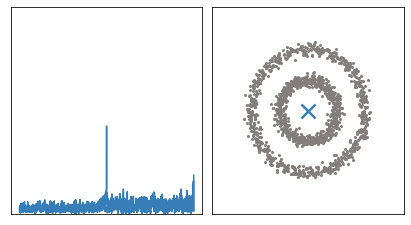

In [155]:
orderedL_X0 = ILS_Single_Label(X[0])

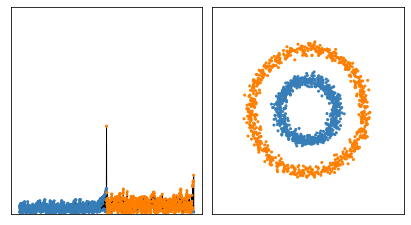

In [214]:
l1 = orderedL_X0.iloc[0, :].name
l2 = orderedL_X0.iloc[int(len(orderedL_X1)/3*2), :].name

X0 = X[0].copy()
X0['label'] = 0
X0.loc[l1,'label'] = 1
X0.loc[l2,'label'] = 2

orderedL_X0.loc[0] = [orderedL_X0['minR'].iloc[0], -1]
df0 = orderedL_X0.merge(X0, left_index=True, right_index=True)
df0['order'] = range(len(df0))

ILS_Cluster_Run(df0, features = ['x','y'])

### Moons

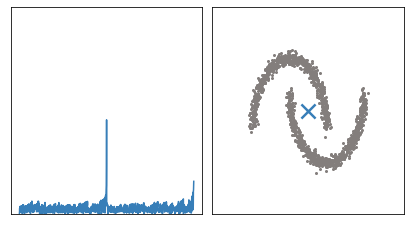

In [161]:
orderedL_X1 = ILS_Single_Label(X[1])

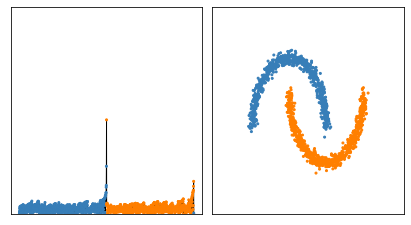

In [215]:
l1 = orderedL_X1.iloc[0, :].name
l2 = orderedL_X1.iloc[int(len(orderedL_X1)/3*2), :].name

X1 = X[1].copy()
X1['label'] = 0
X1.loc[l1,'label'] = 1
X1.loc[l2,'label'] = 2

orderedL_X1.loc[0] = [orderedL_X1['minR'].iloc[0], -1]
df1 = orderedL_X1.merge(X1, left_index=True, right_index=True)
df1['order'] = range(len(df1))

ILS_Cluster_Run(df1, features = ['x','y'])

### Gaussian circle ( differing variances )

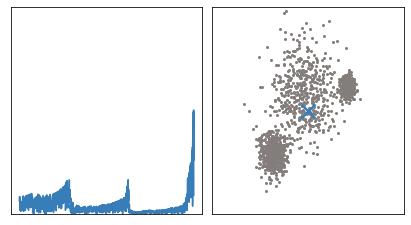

In [162]:
orderedL_X2 = ILS_Single_Label(X[2])

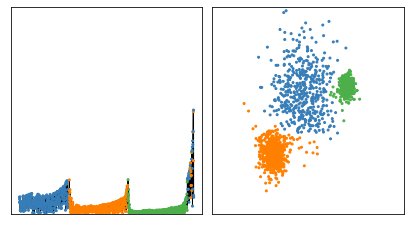

In [216]:
l2 = orderedL_X2.iloc[0, :].name
l2 = orderedL_X2.iloc[int(len(orderedL_X2)/2), :].name
l3 = orderedL_X2.iloc[int(len(orderedL_X2)/4*3), :].name


X2 = X[2].copy()
X2['label'] = 0
X2.loc[l1,'label'] = 1
X2.loc[l2,'label'] = 2
X2.loc[l3,'label'] = 3

orderedL_X2.loc[0] = [orderedL_X2['minR'].iloc[0], -1]
df2 = orderedL_X2.merge(X2, left_index=True, right_index=True)
df2['order'] = range(len(df2))

ILS_Cluster_Run(df2, features = ['x','y'])

### Elongated blobs

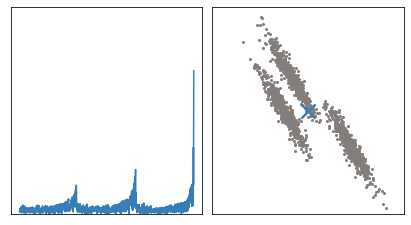

In [163]:
orderedL_X3 = ILS_Single_Label(X[3])

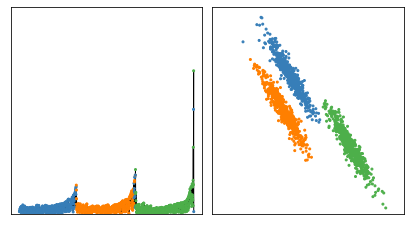

In [218]:
l1 = orderedL_X3.iloc[0, :].name
l2 = orderedL_X3.iloc[int(len(orderedL_X3)/2), :].name
l3 = orderedL_X3.iloc[int(len(orderedL_X3)/4*3), :].name

X3 = X[3].copy()
X3['label'] = 0
X3.loc[l1,'label'] = 1
X3.loc[l2,'label'] = 2
X3.loc[l3,'label'] = 3

orderedL_X3.loc[0] = [orderedL_X3['minR'].iloc[0], -1]
df3 = orderedL_X3.merge(X3, left_index=True, right_index=True)
df3['order'] = range(len(df3))

ILS_Cluster_Run(df3, features = ['x','y'])

### Gaussian circles ( same variance )

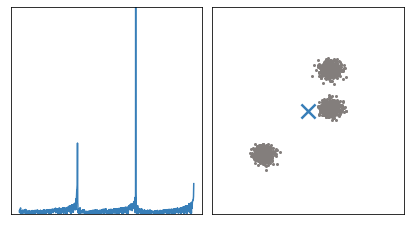

In [164]:
orderedL_X4 = ILS_Single_Label(X[4])

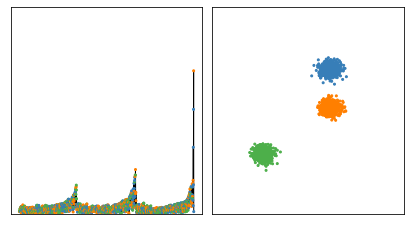

In [219]:
l1 = orderedL_X4.iloc[0, :].name
l2 = orderedL_X4.iloc[int(len(orderedL_X4)/2), :].name
l3 = orderedL_X4.iloc[int(len(orderedL_X4)/4*3), :].name

X4 = X[4].copy()
X4['label'] = 0
X4.loc[l1,'label'] = 1
X4.loc[l2,'label'] = 2
X4.loc[l3,'label'] = 3

orderedL_X4.loc[0] = [orderedL_X4['minR'].iloc[0], -1]
df4 = orderedL_X3.merge(X4, left_index=True, right_index=True)
df4['order'] = range(len(df4))

ILS_Cluster_Run(df4, features = ['x','y'])

### Null case (noise only)

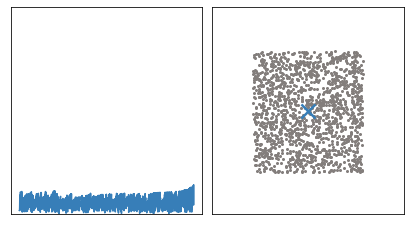

In [165]:
orderedL_X5 = ILS_Single_Label(X[5])

## Assess success of kMeans clustering result using ILS 

### Inset circles

Iterative label spreading took 2.6s to label 756 points
Iterative label spreading took 2.0s to label 744 points


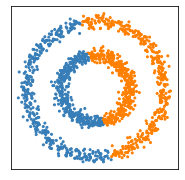

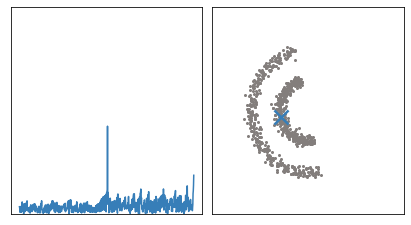

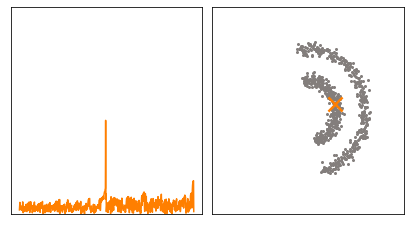

In [220]:
kMeans_success(X[0],2)

### Moons 

Iterative label spreading took 2.0s to label 753 points
Iterative label spreading took 2.0s to label 747 points


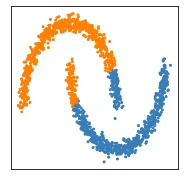

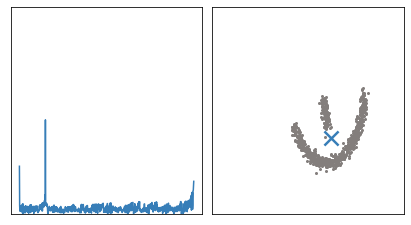

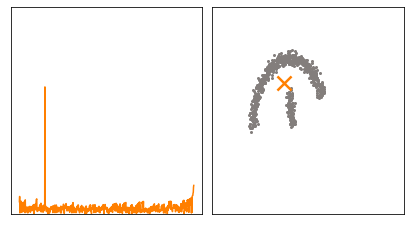

In [221]:
kMeans_success(X[1],2)

### Gaussian circle ( differing variances )

Iterative label spreading took 1.5s to label 566 points
Iterative label spreading took 1.7s to label 538 points
Iterative label spreading took 1.9s to label 396 points


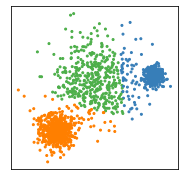

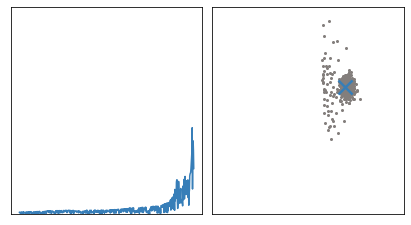

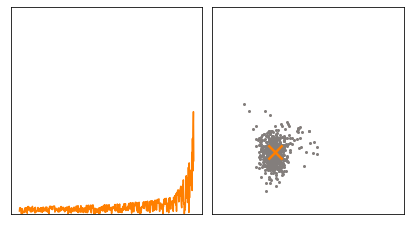

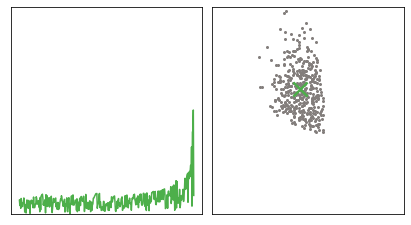

In [222]:
kMeans_success(X[2],3)

### Elongated blobs

Iterative label spreading took 1.4s to label 509 points
Iterative label spreading took 1.4s to label 507 points
Iterative label spreading took 1.2s to label 484 points


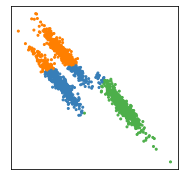

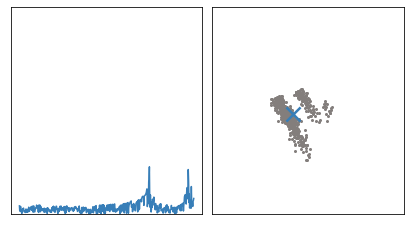

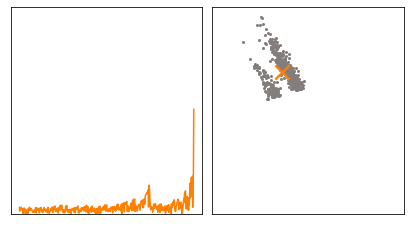

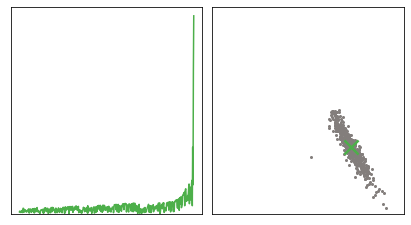

In [223]:
kMeans_success(X[3],3)

### Gaussian circles ( same variance )

Iterative label spreading took 1.5s to label 500 points
Iterative label spreading took 1.3s to label 500 points
Iterative label spreading took 1.2s to label 500 points


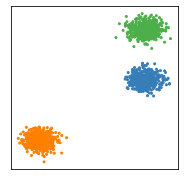

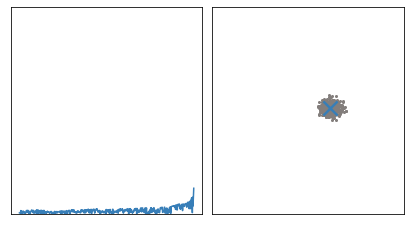

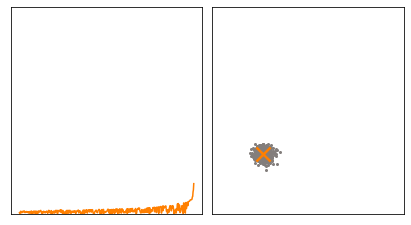

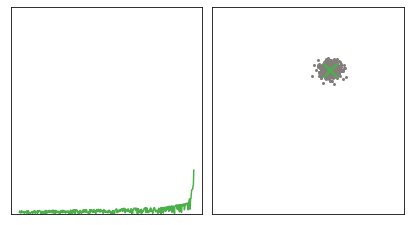

In [224]:
kMeans_success(X[4],3)

### Noise Only

Iterative label spreading took 1.5s to label 533 points
Iterative label spreading took 1.3s to label 475 points
Iterative label spreading took 1.3s to label 492 points


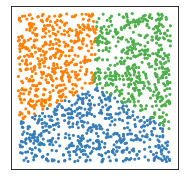

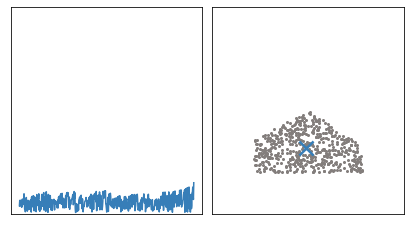

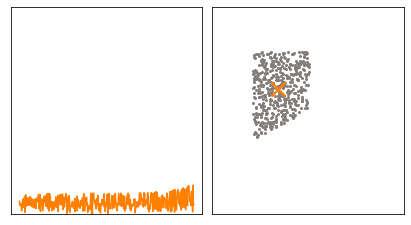

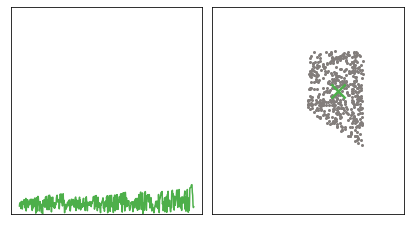

In [225]:
kMeans_success(X[5],3)